## Data Exploration 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

from prepro import readfile, get_sentence, get_label, get_all, get_corpus, extract_words

In [5]:
train = readfile("train.txt")
test = readfile("test.txt")
val = readfile("valid.txt")

In [6]:
def print_head(dataset,sentence_number):
    data = get_all(dataset,sentence_number)
    words =[]
    pos =[]
    chunk = []
    ner =[]
    for i in data:
        words.append(i[0])
        pos.append(i[-1])
        ner.append(i[1])
        chunk.append(i[-2])
        
    df = pd.DataFrame(words, columns=['Words'])
    df["POS"] = pos
    df["NER"] = ner
    df["Chunk"] = chunk
    return(print(df))
    
print_head(train,1)   

     Words  POS     NER Chunk
0       EU  NNP   I-ORG  I-NP
1  rejects  VBZ       O  I-VP
2   German   JJ  I-MISC  I-NP
3     call   NN       O  I-NP
4       to   TO       O  I-VP
5  boycott   VB       O  I-VP
6  British   JJ  I-MISC  I-NP
7     lamb   NN       O  I-NP
8        .    .       O     O


In [7]:
#print out the fist sentence
def print_sentence(sentence_number):
    #use list comprehensions to print the sentence with entity tags
    print("".join(['{:10}'.format(word[0]) for word in train[sentence_number-1]]))
    print("".join(['{:10}'.format(word[1]) for word in train[sentence_number-1]]))

print_sentence(1)

EU        rejects   German    call      to        boycott   British   lamb      .         
I-ORG     O         I-MISC    O         O         O         I-MISC    O         O         


## Properties of the Data

In [8]:
sentences =[len(train),len(val), len(test)]
tokens = [get_corpus(train)[0],get_corpus(val)[0],get_corpus(test)[0]]
uni =[get_corpus(train)[1], get_corpus(val)[1],get_corpus(test)[1]]

df=pd.DataFrame(sentences, columns=["Sentences"])
df['Tokens']=tokens
df['Unique Words'] =uni
df= df.transpose()
df.columns =["Train","Val","Test"]
df

,Train,Val,Test
Sentences,14041,3250,3453
Tokens,203621,51362,46435
Unique Words,21009,9002,8548


In [12]:
#What is the most popular entity - Entity counter

def count_entities(train):
    entities = []
    for sentence in train:
        for word in sentence:
            entities.append(word[1])
    return(Counter(entities))

def unpack_dic(dic1,dic2,dic3,boolean):
    loc = [dic1["I-LOC"] + dic1["B-LOC"],dic2["I-LOC"] + dic2["B-LOC"],dic3["I-LOC"] + dic3["B-LOC"]]
    org = [dic1["I-ORG"] + dic1["B-ORG"],dic2["I-ORG"] + dic2["B-ORG"],dic3["I-ORG"] + dic3["B-ORG"]]
    per = [dic1["I-PER"] + dic1["B-PER"],dic2["I-PER"] + dic2["B-PER"], dic3["I-PER"] + dic3["B-PER"]]
    mis = [dic1["I-MISC"] + dic1["B-MISC"],dic2["I-MISC"] + dic2["B-MISC"], dic3["I-MISC"] + dic3["B-MISC"]]
    O = [dic1["O"],dic2["O"], dic3["O"]]
    
    df = pd.DataFrame(loc, columns=["LOC"])
    df['ORG']=org
    df['PER'] =per
    df['MISC']= mis
    if boolean:
        df['O']= O
    df.rename(index={0:'Train',1:'Val', 2:'Test'}, inplace=True)
    return(df)

train_dic= count_entities(train)
test_dic = count_entities(test)
val_dic = count_entities(val)
unpack_dic(train_dic,val_dic,test_dic, False)

,LOC,ORG,PER,MISC
Train,8297,10025,11128,4593
Val,2094,2092,3149,1268
Test,1925,2496,2773,918


In [9]:
#get data on sentence length
sentences_len = []
for sentence in train:
    sentences_len.append(len(sentence))

for sentence in test:
    sentences_len.append(len(sentence))

for sentence in val:
    sentences_len.append(len(sentence))
    
#training set
print("The average length of sentences is %s words" % round(sum(sentences_len)/len(sentences_len)))
print("The longest senetence has %s words" %max(sentences_len))
print("The shortest senetence has %s word" %min(sentences_len))

The average length of sentences is 15 words
The longest senetence has 124 words
The shortest senetence has 1 word


In [10]:
#how many token with arent alpha numerical
train_words,tags=extract_words(train)
test_words,tags=extract_words(test)
val_words,tags=extract_words(val)

train_words.extend(test_words)
train_words.extend(val_words)

tokens=[]
for i in train_words:
    if i.isalpha() ==False:
        if any(c.isalpha() for c in i):
            continue
        else:
            tokens.append(i)

len(set(tokens))
print ("Total Unique tokens: %d" %len(set(train_words)))
print("There are %d none alphabetic tokens" %len(set(tokens)))

Total Unique tokens: 26869
There are 4856 none alphabetic tokens


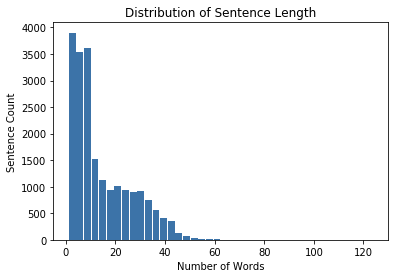

In [11]:
def show_distribution():
    #Show the distribution of sentence length
    plt.hist(sentences_len,bins=40, rwidth=0.9,
                       color='#3c73a8',log=False)
    plt.xlabel('Number of Words')
    plt.ylabel('Sentence Count')
    plt.title("Distribution of Sentence Length")
    plt.savefig('F:\Data Science\Thesis\Write Up\Pictures\Sentence Distribution.png')
    plt.show()

show_distribution()

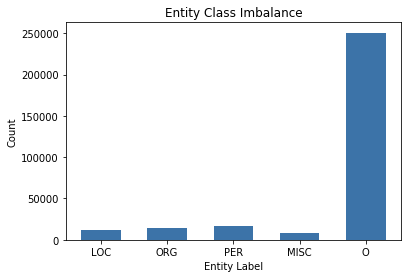

In [12]:
def show_imbalance(train_dic,val_dic, test_dic):
    df=unpack_dic(train_dic,val_dic, test_dic,True)
    labels = list(df.columns)
    values = list(df.sum(axis = 0))
    indexes = np.arange(len(labels))
    width=0.6
    plt.bar(indexes, values, width, color='#3c73a8')
    plt.xticks(indexes + width * 0.0, labels)
    plt.title("Entity Class Imbalance")
    plt.ylabel("Count")
    plt.xlabel("Entity Label")
    plt.savefig('F:\Data Science\Thesis\Write Up\Pictures\Imbalance.png')
    plt.show()
    
show_imbalance(train_dic,val_dic,test_dic)

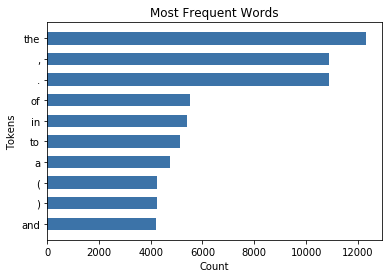

In [13]:
def word_frequency(train, test):
    #Most Common Words
    word_list = extract_words(train)[0]
    word_list.extend(extract_words(test)[0])
    word_list.extend(extract_words(val)[0])

    counts = dict(Counter(word_list))
    sorted_counts = sorted(counts.items(), key=lambda kv: kv[1],  reverse=True)
    labels,values=[],[]
    for i in sorted_counts[:10]:
        labels.append(i[0])
        values.append(i[1])

        #visual
    indexes = np.arange(len(labels))
    width=0.6
    plt.barh(indexes, values, width,align='center', color='#3c73a8')
    plt.yticks(indexes + width * 0.0, labels)
    plt.gca().invert_yaxis()
    plt.xlabel('Count')
    plt.title("Most Frequent Words")
    plt.ylabel("Tokens")
    plt.savefig('F:\Data Science\Thesis\Write Up\Pictures\Word Frequency.png')
    plt.show()

word_frequency(train, test)